In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


[0.20734967 0.7173321  0.71224016 ... 0.07153315 0.0738315  0.07717939]


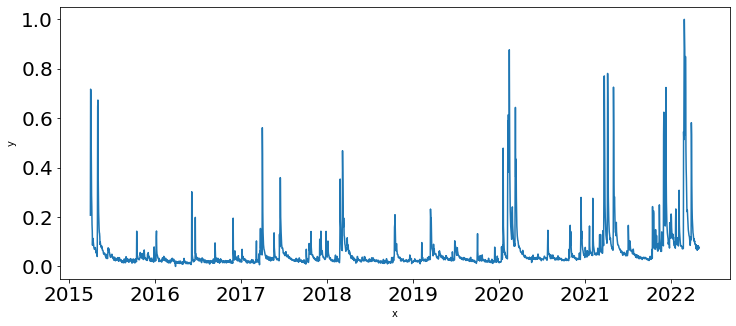

In [2]:
# Prepare DATA
RED_obs = pd.read_csv("RED_Observed.csv")
RED_BOM = pd.read_csv("RED_Rainfall.csv")

# Set date as index and convert to datetime
RED_obs.set_index('Date',inplace=True)
RED_obs.index = pd.to_datetime(RED_obs.index, infer_datetime_format=True).astype('datetime64[ns]')

# Convert columns to numbers
RED_obs['Rainfall'] = pd.to_numeric(RED_obs['Rainfall'], errors='coerce')
RED_obs['Inflow'] = pd.to_numeric(RED_obs['Inflow'], errors='coerce')
RED_obs['Inflow'].fillna(method='ffill', inplace=True)

# Convert date columns to a single datetime and set as index then remove the leftover columns
RED_BOM['Date'] = pd.to_datetime(RED_BOM[['Year','Month','Day']])
RED_BOM.set_index('Date',inplace=True)
RED_BOM.drop(['Year','Month','Day', 'Period over which rainfall was measured (days)', 'Quality'], axis=1, inplace=True)

RED_BOM.rename(columns = {'Rainfall amount (millimetres)': 'Rainfall'},inplace=True)
RED_BOM.dropna(inplace=True)

# Combine the RED_BOM and RED_obs into one df

df = RED_obs.join(RED_BOM, lsuffix='_obs', rsuffix='_BOM') # Left Join on RED_obs
df['Rainfall_BOM'].fillna(method='ffill', inplace=True)
df.dropna(inplace=True)


# Create generic x, y from flows 
dates = df.index.values
N = len(df['Inflow'])
x = df.index.values
y = df['Inflow'].values.astype(np.float32)
# y = np.log(y)

# normalise y
y = (y- min(y))/(max(y)-min(y))

print(y)

plt.figure(figsize=(12,5))
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y)

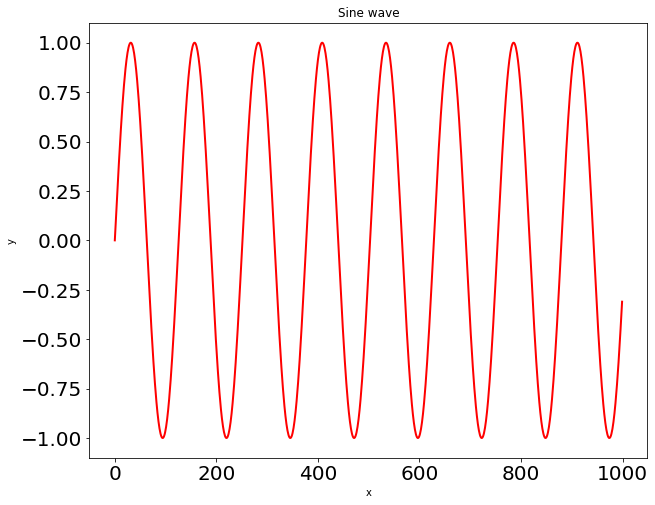

In [234]:
# Generate some easy data for testing the model training works

N = 1
L = 1000
T = 20


x = np.empty(L, np.float32)
x = np.array(range(L))
x = np.array(range(L))
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[0]), y[:],'r', linewidth=2.0)
plt.show()

In [309]:
# Setup CPU
device = torch.device("cpu")

In [3]:
# Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [229]:
# DEPRECATED Convert data set to tensors (LSTMCell)
num_train = 365 # How many training samples to use
num_test = 100 # How many training samples to use

train_data = y[:num_train]
train_target = y[1:num_train+1]

test_data = y[num_train:num_train+num_test]
test_target = y[num_train+1:num_train+num_test+1]

train_input = torch.tensor(train_data)
test_input = torch.tensor(test_data)

train_target = torch.tensor(train_target)
test_target = torch.tensor(test_target)

print(train_input.shape)


torch.Size([365])


In [4]:
# Convert data set to tensors (LSTM)
split_frac = 0.8

num_train = round(split_frac * len(y))# How many training samples to use
num_test = round((1-split_frac) * len(y)) # How many training samples to use

train_data = y[:num_train-1]
train_target = y[1:num_train]

test_data = y[num_train-1:num_train+num_test-1]
test_target = y[num_train:num_train+num_test]

train_input = torch.tensor(train_data).unsqueeze(-1)
test_input = torch.tensor(test_data).unsqueeze(-1)

train_target = torch.tensor(train_target).unsqueeze(-1)
test_target = torch.tensor(test_target).unsqueeze(-1)

if torch.cuda.is_available():
    train_input = train_input.to(device)
    test_input = test_input.to(device)
    train_target = train_target.to(device)
    test_target = test_target.to(device)

print(num_train, len(test_target), len(y))

2060 515 2575


In [4]:
# DEORECATED LSTM Class (LSTMCell)

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()

        self.n_hidden = n_hidden
        
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)

        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Propogate input through LSTM for future values
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Convert list to tensor
        outputs = torch.cat(outputs, dim=0)
        return outputs



In [5]:
# LSTM Class 2

class LSTMPredictor2(nn.Module):
    def __init__(self, device, input_dim=1, n_layers=2, hidden_dim=51, ):
        super(LSTMPredictor2, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        
        # stacked lstm, linear
        self.lstm = nn.LSTM(1, self.hidden_dim, self.n_layers)
        self.Linear = nn.Linear(self.hidden_dim, 1)


    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h0 = torch.zeros(self.n_layers, self.hidden_dim)
        c0 = torch.zeros(self.n_layers, self.hidden_dim)

        if torch.cuda.is_available():
            h0 = h0.to(self.device)
            c0 = c0.to(self.device)
        
        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            lstm_out, (h0, c0) = self.lstm(input_t, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        # Propogate input through LSTM for future values
        for i in range(future):
            lstm_out, (h0, c0) = self.lstm(output, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=0)
        return outputs

        

In [6]:
# Initialize model
# model = LSTMPredictor()
model = LSTMPredictor2(device, input_dim=1, n_layers=10, hidden_dim=64)
if torch.cuda.is_available():
    model = model.to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.LBFGS(model.parameters(), lr=0.8)
test_losses = {}
train_losses = {}

In [7]:
# Training loop

epochs = 1000
for i in range(epochs):
    print("Epoch", i+1)

    # Train model
    def closure():
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = criterion(outputs, train_target)
        print("loss", loss.item())
        train_losses[i] = loss.item()
        loss.backward()
        return loss

    optimizer.step(closure)


    # Evaluate model
    with torch.no_grad():
        future = 365
        pred = model(test_input, future=future)
        loss = criterion(pred[:-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().cpu().numpy()
    
    test_losses[i] = loss.item()

    if i==0 or (i+1) % 100 == 0:
        # Plot the prediction
        plt.figure(figsize=(12,5))
        plt.title(f"Step: {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        n = train_input.shape[0] # 2475
        ntest = test_input.shape[0] # 100
        future = 365

        # Draw original data
        plt.plot(np.arange(n), train_input.cpu(), 'r', linewidth=2.0)
        plt.plot(np.arange(n, n + ntest), test_input.cpu(), 'b', linewidth=2.0)
        plt.plot(np.arange(n, n + ntest + future), y, 'g', linewidth=2.0)
        plt.savefig(f"images/10_layers/step{i+1}.png")
        plt.close()

Epoch 1
loss 0.004602475557476282
test loss 0.02824445627629757
Epoch 2
loss 0.004498596768826246
test loss 0.028520600870251656
Epoch 3
loss 0.004538217559456825
test loss 0.027040371671319008
Epoch 4
loss 0.004377473145723343
test loss 0.025571195408701897
Epoch 5
loss 0.004372544586658478
test loss 0.024833261966705322
Epoch 6
loss 0.00444853724911809
test loss 0.02487175352871418
Epoch 7
loss 0.0044426037929952145
test loss 0.025441108271479607
Epoch 8
loss 0.004380613565444946
test loss 0.026269663125276566
Epoch 9
loss 0.0043509178794920444
test loss 0.02703351154923439
Epoch 10
loss 0.004375578835606575
test loss 0.027421362698078156
Epoch 11
loss 0.004404093604534864
test loss 0.027323277667164803
Epoch 12
loss 0.004395253024995327
test loss 0.02686271257698536
Epoch 13
loss 0.004364467225968838
test loss 0.026266086846590042
Epoch 14
loss 0.004348147660493851
test loss 0.025749551132321358
Epoch 15
loss 0.004358180332928896
test loss 0.025457119569182396
Epoch 16
loss 0.004374

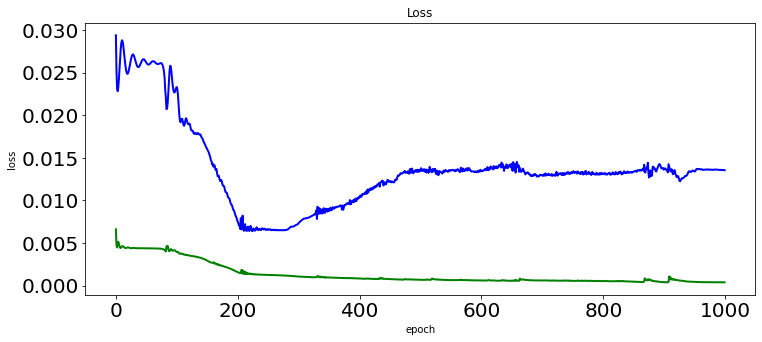

In [42]:
losses1 = pd.DataFrame([test_losses]).T
losses1.columns = ["test"]
losses2 = pd.DataFrame([train_losses]).T
losses2.columns = ["train"]

plt.figure(figsize=(12,5))
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(losses1.index, losses1["test"], 'b', linewidth=2.0)
plt.plot(losses2.index, losses2['train'], 'g', linewidth=2.0)